### Simulation routine for figure 3

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from data_prep import load_data
from strategic import best_response
from optimization import logistic_regression, evaluate_loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib
import time
import pandas as pd

In [ ]:
# Plotting fonts setup
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 16}) 

We perform our experiments on the *Give me a credit* dataset available at https://www.kaggle.com/c/GiveMeSomeCredit. The dataset contains features of individuals and an indicator varaible on whether they defaulted on a loan or not.

## Section 6.2: Alignment and misreporting

Simulation of the accuracy drop against concealing each feature. Each bar corresponds to a fracture that is being misreported. The values of the bars indicate the drop of test accuracy compared to the baseline classifier. This will generate **figure 2** in the paper. For each feature $x_i$, agents replace their true value $x_i$ with a target value $\hat{x}_i$, which we sample independently from a standard normal distribution. Subsequently, we retrain a logistic regression classifier for each scenario, using data in which the respective feature has been misreported.

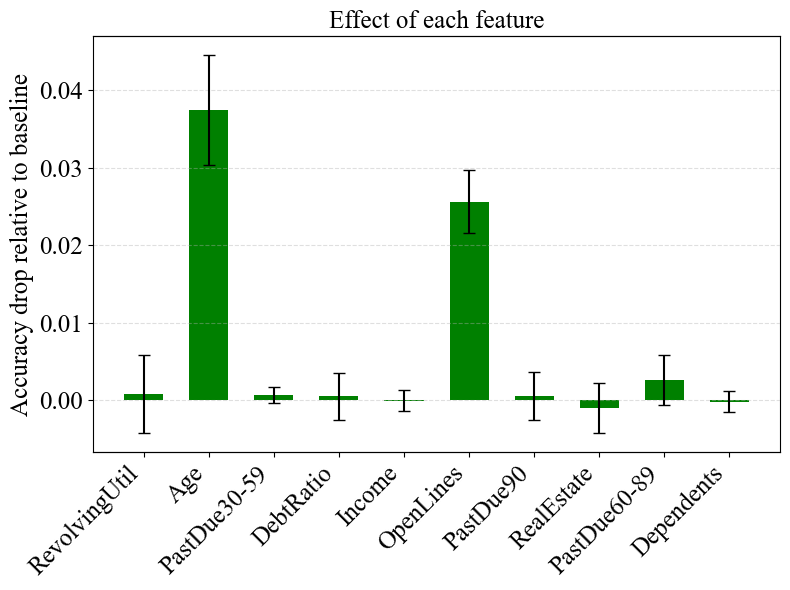

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

# ---- data ---- #
X, Y, data = load_data("./cs-training.csv")
X = X[:, 1:]

# ---- config ---- #
seed = 1111
n_repeat = 100                 # <--- number of simulation repeats
fsize = 18
titlesize = 18
width = 0.6

feat_labels = [
    'RevolvingUtil', 'Age', 'PastDue30-59', 'DebtRatio', 'Income',
    'OpenLines', 'PastDue90', 'RealEstate', 'PastDue60-89', 'Dependents'
]

n_cols = X.shape[1]
assert len(feat_labels) == n_cols, "Number of labels must match number of features."

# ---- run repeats ---- #
deltas = np.zeros((n_repeat, n_cols))   # delta = baseline_acc - replaced_feature_acc

for r in range(n_repeat):
    # 1) split
    rs = seed + r
    X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.2, random_state=rs)
    n_samples, _ = X_tr.shape

    # 2) baseline
    base_clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=rs)
    base_clf.fit(X_tr, y_tr)
    base_test_acc = accuracy_score(y_te, base_clf.predict(X_te))

    # 3) replace each feature
    rng = np.random.default_rng(rs)
    for j in range(n_cols):
        Xp_tr = X_tr.copy()
        Xp_tr[:, j] = rng.standard_normal(n_samples)  # replace column j with noise

        clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=rs)
        clf.fit(Xp_tr, y_tr)
        acc_rep = accuracy_score(y_te, clf.predict(X_te))

        deltas[r, j] = base_test_acc - acc_rep

# ---- aggregate: mean and error (std across repeats) ---- #
mean_delta = deltas.mean(axis=0)
err_delta  = deltas.std(axis=0, ddof=1)   # error bar = standard deviation

# ---- plot ---- #
x = np.arange(n_cols)
fig, ax = plt.subplots(figsize=(8, 6))  # use a narrower figure if you like

# use twin axis then move right axis to left (keep left axis hidden)
ax2 = ax.twinx()
bars = ax2.bar(
    x, mean_delta, width, color='green',
    yerr=err_delta, error_kw={'capsize': 4, 'elinewidth': 1.5}
)

# remove original left axis
ax.set_yticks([])
ax.spines['left'].set_visible(False)

# move right axis to left
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.spines['right'].set_visible(False)

ax2.set_ylabel('Accuracy drop relative to baseline', fontsize=fsize)
ax2.tick_params(axis='both', labelsize=fsize)

ax.set_xticks(x)
ax.set_xticklabels(feat_labels, rotation=45, ha='right', fontsize=fsize)

plt.title('Effect of each feature', fontsize=titlesize)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout(pad=1.08)
plt.savefig("feature-effect-error-bar.pdf")
plt.show()


## Section 6.2 Utilitarian Agents: Agent utilities and the benefit of participation

In [4]:
# optimise_dataset_utility_single_feature.py
# ------------------------------------------
# Assumptions:
#   X : numpy array (N,d)   – features
#   y : numpy array (N,)    – 0/1 labels
#
# Utility  u_i = (θᵀx_i) + x_{i,2}
# Only ONE feature column is editable for the beta-fraction of rows.

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ----------------- device --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ================================================================
# 0.  bring your data (X, y) here
# ------------------------------------------------
X, y, data = load_data('./cs-training.csv')
n = X.shape[0]
d = X.shape[1] - 1
X = X[:, 1:]
# ================================================================

# ------------------------------------------------------------------

N, d = X.shape
X_t = torch.tensor(X, dtype=torch.float32, device=device)
y_t = torch.tensor(y.reshape(-1), dtype=torch.float32, device=device)
X_ori = X_t.detach().clone()
print(X_ori)

# 1. differentiable θ* ---------------------------------------------
def train_theta_diff(X, Y, iters=100):
    θ = torch.zeros(d, requires_grad=True, device=X.device)
    for i in range(iters):
        loss = F.binary_cross_entropy_with_logits(X @ θ, Y)
        (g,) = torch.autograd.grad(loss, θ, create_graph=True)
        lr = max(0.001, 1/(i+1))
        θ = θ - lr * g
        # print(torch.norm(g))
    return θ

# 2. helper for CE per sample --------------------------------------
def ce_vec(logits, targets):
    return F.binary_cross_entropy_with_logits(logits, targets, reduction="none")

# 3. Uniform utility definition
def utility_all(X, Y, θ, lambd):
    logits = X @ θ
    return ce_vec(logits, Y) - lambd * torch.linalg.norm(X - X_ori, axis=1)**2

# 4. subgroup utility tensor -----------------------
def subgroup_util_tensor(X, Y, mask_S, lambd):
    θ = train_theta_diff(X, Y)
    u_i = utility_all(X, Y, θ, lambd)
    return u_i[mask_S].mean()           # tensor (has grad)

# 4. compute final metrics (floats) --------------------------------
def metrics_on_final(X, Y, mask_S, lambd):
    θ = train_theta_diff(X, Y)
    logits = X @ θ
    ce_loss = F.binary_cross_entropy_with_logits(logits, Y).item()
    u = utility_all(X, Y, θ, lambd)
    u_manip = u[mask_S].mean().item()
    u_fixed = u[~mask_S].mean().item()
    return u_manip, u_fixed, u_manip - u_fixed, ce_loss, θ, mask_S, X

# 5. optimisation with only ONE editable column --------------------
def optimise_subset_feature(X0, Y0, j_feat, beta, lambd,
                            outer_iters=150, outer_lr=0.01,
                            seed=1234, use_lbfgs=False):

    N = X0.shape[0]
    k = int(beta * N)

    rng = torch.Generator(device=device).manual_seed(seed)
    idx_S = torch.randperm(N, generator=rng, device=device)[:k]
    mask_S = torch.zeros(N, dtype=torch.bool, device=device)
    mask_S[idx_S] = True

    # (N,d) mask: True only for rows in S and column j_feat
    mask_grad = torch.zeros_like(X0, dtype=torch.bool, device=device)
    mask_grad[mask_S, j_feat] = True

    X_var = X0.clone().detach().to(device).requires_grad_(True)

    opt = (torch.optim.LBFGS([X_var], lr=outer_lr, max_iter=20)
           if use_lbfgs else
           torch.optim.Adam([X_var], lr=outer_lr))

    for _ in range(outer_iters):

        def closure():
            opt.zero_grad()
            util = subgroup_util_tensor(X_var, Y0, mask_S, lambd)
            loss = -util                      # maximise utility
            loss.backward()

            # zero gradients everywhere except the editable column
            with torch.no_grad():
                X_var.grad[~mask_grad] = 0
            return loss

        if use_lbfgs:
            opt.step(closure)
        else:
            closure()
            opt.step()

    return metrics_on_final(X_var.detach(), Y0, mask_S, lambd)

# --------------------------------------------------------------------
# Helper to compute gradients & Hessian statistics wrt θ
# --------------------------------------------------------------------
def grad_hessian_metrics(X, Y, θ, mask_S):
    """
    Computes:
      - mean grad_θ u(z,θ) over manip group
      - mean grad_θ loss(z,θ) over manip group
      - Hessian H = ∇²_θ L(X,θ)
      - mean Jacobian ∂(∇θ u)/∂X over manip group
    """
    X = X.clone().detach().to(device).requires_grad_(True)
    θ = θ.detach().clone().to(device).requires_grad_(True)

    logits = X @ θ
    ce_i = F.binary_cross_entropy_with_logits(logits, Y, reduction="none")

    grads_loss, grads_util, jacobians = [], [], []

    for i in range(X.shape[0]):
        # ∇θℓ
        g_li = torch.autograd.grad(ce_i[i], θ, retain_graph=True)[0]

        # utility u_i = -ℓ_i (modify if you have your own)
        u_i = -ce_i[i]
        g_ui = torch.autograd.grad(u_i, θ, retain_graph=True, create_graph=True)[0]

        # compute ∂(∇θu_i)/∂X[i,:] using vector–Jacobian product trick
        jac_rows = []
        for j in range(g_ui.numel()):
            jac_component = torch.autograd.grad(
                g_ui[j], X, retain_graph=True,
                grad_outputs=torch.ones_like(g_ui[j])
            )[0][i, :]
            jac_rows.append(jac_component)
        jac = torch.stack(jac_rows)  # shape: (dθ, dX)
        jacobians.append(jac)

        grads_loss.append(g_li)
        grads_util.append(g_ui)

    grads_loss = torch.stack(grads_loss)
    grads_util = torch.stack(grads_util)
    jacobians = torch.stack(jacobians)

    g_loss_mean = grads_loss[mask_S].mean(0)
    g_util_mean = grads_util[mask_S].mean(0)
    jac_mean = jacobians[mask_S].mean(0)

    def loss_fn(th):
        return F.binary_cross_entropy_with_logits(X @ th, Y)

    H = torch.autograd.functional.hessian(loss_fn, θ).detach()

    eps = 1e-5 * torch.eye(H.shape[0], device=H.device)
    H = H + eps

    return g_util_mean.detach(), g_loss_mean.detach(), H, jac_mean.detach()

def performative_stable_point(X_t, y_t, feat_idx, beta, lambd,
                              outer_rounds=50,
                              inner_iters=100,
                              inner_lr=0.01,
                              seed=1234,
                              use_lbfgs=False):
    """
    Alternating procedure:
      (A) Fix θ_t, maximise subgroup utility by editing ONLY column `feat_idx`
          for the β-fraction rows (inner_iters steps).
      (B) Fix modified X, re-train θ via train_theta_diff.
    Repeat for `outer_rounds`. Returns (u_manip, u_fixed, delta, ce_loss).
    """
    N, d = X_t.shape
    k = int(beta * N)

    # Select editable subset S (reproducibly)
    rng = torch.Generator(device=device).manual_seed(seed)
    idx_S = torch.randperm(N, generator=rng, device=device)[:k]
    mask_S = torch.zeros(N, dtype=torch.bool, device=device)
    mask_S[idx_S] = True

    # Gradient mask: only rows in S AND the chosen feature column are editable
    mask_grad = torch.zeros_like(X_t, dtype=torch.bool, device=device)
    mask_grad[mask_S, feat_idx] = True

    # Start from current θ and clone data to edit
    theta = train_theta_diff(X_t, y_t).detach()     # <-- DETACH θ to "freeze" it
    X_var = X_t.clone().detach().to(device).requires_grad_(True)

    # Optimiser for data edits
    opt = (torch.optim.LBFGS([X_var], lr=inner_lr, max_iter=20)
           if use_lbfgs else
           torch.optim.Adam([X_var], lr=inner_lr))

    for _ in range(outer_rounds):
        # --- (A) optimise data with θ fixed ---
        for _inner in range(inner_iters):
            def closure():
                opt.zero_grad()
                # use the detached/frozen theta
                u_all = utility_all(X_var, y_t, theta, lambd)   # (N,)
                util = u_all[mask_S].mean()
                loss = -util                              # maximise util
                loss.backward()
                with torch.no_grad():
                    # zero grads everywhere except the allowed coordinates
                    X_var.grad[~mask_grad] = 0
                return loss

            if use_lbfgs:
                opt.step(closure)
            else:
                closure()
                opt.step()

        # --- (B) re-train θ on the modified data; then DETACH it again ---
        with torch.no_grad():
            X_fixed = X_var.detach().clone()
        theta = train_theta_diff(X_fixed, y_t).detach()   # <-- DETACH for next round

    # Final metrics at the performative-stable point
    return metrics_on_final(X_var.detach(), y_t, mask_S, lambd)

# 6. sweep over feature-index × beta grid ------------------------------
beta_list = np.linspace(0.01, 0.99, 10)
feat_idx = 1  # 1 and 9
n_runs = 10

# Initial utility
theta_0 = train_theta_diff(X_t, y_t)
u = utility_all(X_t, y_t, theta_0, lambd=0.5)
print(u.mean())

print("\nAverage utilities after single-feature maximisation")
print("--------------------------------------------------------------------------")
hdr = f"{'feat':>4} {'beta':>5} | {'u_manip':>10} {'u_fixed':>10} {'Δ':>10} {'CE':>10} {'align':>10}"
print(hdr); print("-"*len(hdr))

count_plot = 0

rec_u_dict = {}
rec_gap_dict = {}
rec_align_dict = {}
rec_ups_dict = {}

for run in range(n_runs):
    rec_u, rec_gap, rec_align, rec_ups = [], [], [], []
    np.random.seed(21 + run)
    torch.manual_seed(42 + run)
    for lambd in beta_list:
        beta = 1
        u_m, u_f, gap, ce_val, theta, mask_S, X_sharp = optimise_subset_feature(
            X_t, y_t, feat_idx, beta, lambd,
            outer_iters=250, outer_lr=0.01,
            use_lbfgs=False, seed=42 + run
        )

        u_ps, u_f_ps, gap_ps, ce_val_ps, theta_sharp, mask_S, X_star = performative_stable_point(
            X_t, y_t, feat_idx, beta, lambd
        )

        g_u, _ , H, jac = grad_hessian_metrics(X_star, y_t, theta, mask_S)
        _, g_lps ,_ ,_ = grad_hessian_metrics(X_sharp, y_t, theta, mask_S)

        H_inv = torch.inverse(H)
        align_val = torch.norm(jac @ H_inv @ g_lps).item()

        rec_u.append(u_m)
        rec_gap.append(gap)
        rec_align.append(align_val)
        rec_ups.append(u_ps)

        print(u_m, u_ps, u_m - u_ps, align_val**2)
    
    rec_u_dict[run] = rec_u
    rec_gap_dict[run] = rec_gap
    rec_align_dict[run] = rec_align
    rec_ups_dict[run] = rec_ups


Using device: cuda
tensor([[-1.3371, -0.1091, -0.0608,  ..., -0.0545,  0.1290,  1.0000],
        [-0.0894, -0.1091, -0.0622,  ..., -0.0545,  3.6122,  1.0000],
        [-0.0201, -0.1091,  4.8932,  ..., -0.0545,  0.1290,  1.0000],
        ...,
        [ 0.3265,  0.1767, -0.0620,  ...,  0.2356, -0.7418,  1.0000],
        [ 0.3265, -0.1091, -0.0617,  ..., -0.0545,  0.9998,  1.0000],
        [-0.8519, -0.1091, -0.0620,  ..., -0.0545,  0.1290,  1.0000]],
       device='cuda:0')
tensor(0.6497, device='cuda:0', grad_fn=<MeanBackward0>)

Average utilities after single-feature maximisation
--------------------------------------------------------------------------
feat  beta |    u_manip    u_fixed          Δ         CE      align
-------------------------------------------------------------------
0.6586886048316956 0.6388407945632935 0.0198478102684021 0.0100610942102064
0.65774005651474 0.5343570113182068 0.1233830451965332 0.012039354562122517
0.6570597887039185 0.4970731735229492 0.1599866151

KeyboardInterrupt: 

### Result retrieval

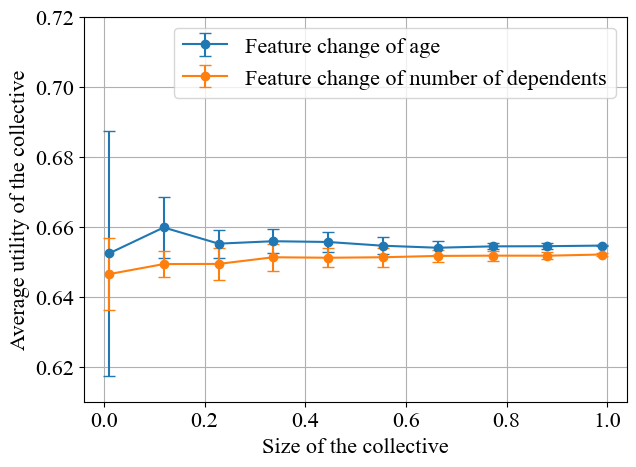

In [ ]:
df_util_nz_age = pd.read_csv("utilities_age_10runs_non_zero_sum.csv")
df_util_nz_nd = pd.read_csv("utilities_nd_10runs_non_zero_sum.csv")

df_util_nz_age   = df_util_nz_age.drop(['Unnamed: 0'], axis = 1)
df_util_nz_nd = df_util_nz_nd.drop(['Unnamed: 0'], axis = 1)


mean_util_age = df_util_nz_age.mean(axis = 1)
mean_util_nd = df_util_nz_nd.mean(axis = 1)

std_util_age = df_util_nz_age.std(axis = 1)
std_util_nd = df_util_nz_nd.std(axis = 1)

plt.figure(figsize=(7,5))
plt.errorbar(
    x=beta_list,
    y=mean_util_age,
    yerr=std_util_age,
    fmt='-o',
    capsize=4,
    label='Feature change of age'
)
plt.errorbar(
    x=beta_list,
    y=mean_util_nd,
    yerr=std_util_nd,
    fmt='-o',
    capsize=4,
    label='Feature change of number of dependents'
)
plt.grid()
plt.ylim([0.61, 0.72])
plt.xlabel('Size of the collective')
plt.ylabel('Average utility of the collective')
plt.legend()
plt.savefig("utility_vs_size_non_zero_sum.pdf")

In [ ]:
if feat_idx == -1:
    df_util_nd = pd.DataFrame(rec_u_dict)
    df_gap_nd = pd.DataFrame(rec_gap_dict)
    df_align_age = pd.DataFrame(rec_align_dict)

    df_util_nd.to_csv("utilities_nd_10runs_with_align.csv")
    df_gap_nd.to_csv("gap_nd_10runs_with_align.csv")
    df_align_age.to_csv("align_nd_10runs.csv")

In [ ]:
if feat_idx == -1:
    df_util_nd = pd.DataFrame(rec_u_dict)
    df_gap_nd = pd.DataFrame(rec_gap_dict)

    df_util_nd.to_csv("utilities_nd_10runs_non_zero_sum.csv")
    df_gap_nd.to_csv("gap_nd_10runs_non_zero_sum.csv")

In [ ]:
if feat_idx == 1:
    df_util_age = pd.DataFrame(rec_u_dict)
    df_gap_age = pd.DataFrame(rec_gap_dict)

    df_util_age.to_csv("utilities_age_10runs.csv")
    df_gap_age.to_csv("gap_age_10runs.csv")

In [ ]:
if feat_idx == 1:
    df_util_age = pd.DataFrame(rec_u_dict)
    df_gap_age = pd.DataFrame(rec_gap_dict)

    df_util_age.to_csv("utilities_age_10runs_non_zero_sum.csv")
    df_gap_age.to_csv("gap_age_10runs_non_zero_sum.csv")

In [ ]:
if feat_idx == 1:
    df_util_age = pd.DataFrame(rec_u_dict)
    df_gap_age = pd.DataFrame(rec_gap_dict)
    df_align_age = pd.DataFrame(rec_align_dict)

    df_util_age.to_csv("utilities_age_10runs_with_align.csv")
    df_gap_age.to_csv("gap_age_10runs_with_align.csv")
    df_align_age.to_csv("align_age_10runs_with_align.csv")

In [ ]:
rec_align_dict

{0: -0.22156685590744019,
 1: -0.22472251951694489,
 2: -0.22410164773464203,
 3: -0.22606372833251953,
 4: -0.2261759340763092,
 5: -0.22483159601688385,
 6: -0.24975243210792542,
 7: -0.2258261740207672,
 8: -0.22813287377357483,
 9: -0.2216493785381317}

          0         1         2         3         4         5         6  \
0  0.717088  0.713674  0.717268  0.711610  0.715348  0.713064  0.710206   
1  0.689927  0.689775  0.689156  0.690170  0.688787  0.688612  0.689272   
2  0.687388  0.687567  0.688035  0.687268  0.686183  0.686374  0.686758   
3  0.686054  0.686343  0.686626  0.686106  0.685516  0.685732  0.686370   
4  0.685332  0.685880  0.685762  0.685900  0.684899  0.685309  0.685918   
5  0.685390  0.685345  0.685872  0.685816  0.684943  0.685255  0.685657   
6  0.685195  0.685260  0.685639  0.685376  0.685002  0.685060  0.685283   
7  0.685144  0.685256  0.685537  0.685255  0.684960  0.685300  0.685067   
8  0.685191  0.685126  0.685342  0.685046  0.685033  0.685254  0.684979   
9  0.685019  0.685060  0.685131  0.685067  0.685083  0.685058  0.685021   

          7         8         9  
0  0.714863  0.709579  0.716828  
1  0.688905  0.690519  0.690167  
2  0.686415  0.687778  0.688029  
3  0.685737  0.686582  0.686644  
4  0

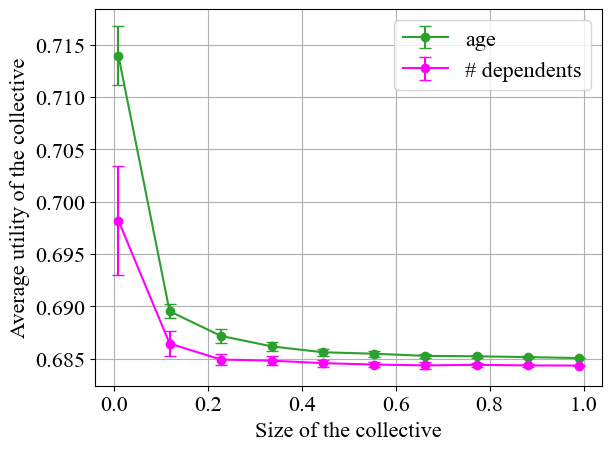

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Plotting fonts setup
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 16}) 
beta_list = np.linspace(0.01, 0.99, 10)
df_util_age = pd.read_csv("utilities_age_10runs.csv")
df_util_nd = pd.read_csv("utilities_nd_10runs.csv")

df_util_age  = df_util_age.drop(['Unnamed: 0'], axis = 1)
df_util_nd = df_util_nd.drop(['Unnamed: 0'], axis = 1)

print(df_util_age)
mean_util_age = df_util_age.mean(axis = 1)
mean_util_nd = df_util_nd.mean(axis = 1)

std_util_age = df_util_age.std(axis = 1)
std_util_nd = df_util_nd.std(axis = 1)

plt.figure()
plt.errorbar(
    x=beta_list,
    y=mean_util_age,
    yerr=std_util_age,
    fmt='-o',
    capsize=4,
    label='age',
    c = 'tab:green'
)
plt.errorbar(
    x=beta_list,
    y=mean_util_nd,
    yerr=std_util_nd,
    fmt='-o',
    capsize=4,
    label='# dependents',
    c = 'magenta'
)
plt.grid()
plt.xlabel('Size of the collective')
plt.ylabel('Average utility of the collective')
plt.legend()
plt.tight_layout()
plt.savefig("utility_vs_size.pdf")
plt.savefig("utility_vs_size.png")

          0         1         2         3         4         5         6  \
0  0.198026  0.125221  0.199725  0.217155  0.171650  2.975447  0.499557   
1  0.090584  0.041483  0.073183  0.066041  0.063361  0.148575  0.164671   
2  0.110218  0.070699  0.065591  0.091863  0.104770  0.049628  0.116268   
3  0.060366  0.054974  0.092754  0.113712  0.094355  0.050384  0.092468   
4  0.052751  0.058510  0.087099  0.124187  0.089781  0.052294  0.088899   
5  0.059318  0.071800  0.068759  0.134032  0.098188  0.062465  0.083640   
6  0.068497  0.079996  0.079316  0.122143  0.094458  0.071893  0.071462   
7  0.079938  0.090652  0.073310  0.082091  0.088938  0.071875  0.081144   
8  0.079203  0.079787  0.081697  0.088392  0.077553  0.071630  0.088772   
9  0.078855  0.079142  0.078661  0.078742  0.085895  0.079197  0.079095   

          7         8         9  
0  0.208545  0.237985  0.208088  
1  0.070075  0.080122  0.093918  
2  0.054988  0.076246  0.109273  
3  0.061792  0.094052  0.072343  
4  0

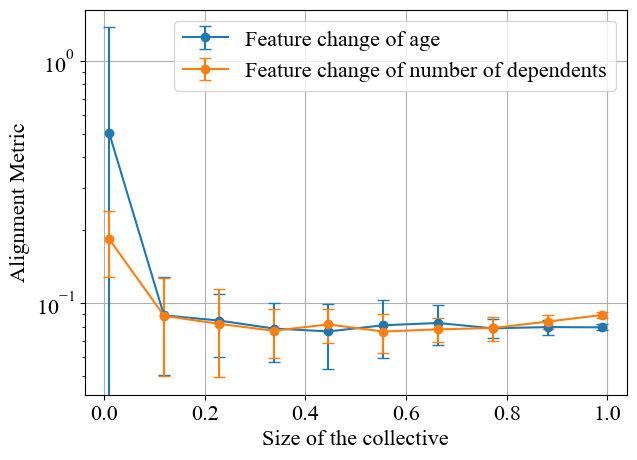

In [ ]:
df_util_age = pd.read_csv("align_age_10runs_with_align.csv")
df_util_nd = pd.read_csv("align_nd_10runs.csv")

df_util_age  = df_util_age.drop(['Unnamed: 0'], axis = 1)
df_util_nd = df_util_nd.drop(['Unnamed: 0'], axis = 1)

print(df_util_age)
mean_util_age = df_util_age.mean(axis = 1)
mean_util_nd = df_util_nd.mean(axis = 1)

std_util_age = df_util_age.std(axis = 1)
std_util_nd = df_util_nd.std(axis = 1)

plt.figure(figsize=(7,5))
plt.errorbar(
    x=beta_list,
    y=mean_util_age,
    yerr=std_util_age,
    fmt='-o',
    capsize=4,
    label='Feature change of age'
)
plt.errorbar(
    x=beta_list,
    y=mean_util_nd,
    yerr=std_util_nd,
    fmt='-o',
    capsize=4,
    label='Feature change of number of dependents'
)
plt.grid()
plt.xlabel('Size of the collective')
plt.ylabel('Alignment Metric')
plt.yscale('log')
#plt.title('Zero-sum case')
plt.legend()
plt.savefig("alignment_metric_vs_size.pdf")

          0         1         2         3         4         5         6  \
0  0.033442  0.029996  0.033624  0.027912  0.031686  0.029381  0.026495   
1  0.005762  0.005585  0.004876  0.006051  0.004447  0.004263  0.005010   
2  0.003222  0.003465  0.004071  0.003083  0.001639  0.001903  0.002399   
3  0.001664  0.002122  0.002539  0.001766  0.000859  0.001202  0.002163   
4  0.000624  0.001642  0.001413  0.001686 -0.000153  0.000603  0.001709   
5  0.000867  0.000769  0.001969  0.001856 -0.000148  0.000580  0.001481   
6  0.000512  0.000705  0.001840  0.001071 -0.000078  0.000121  0.000768   
7  0.000462  0.000957  0.002196  0.000979 -0.000358  0.001164  0.000116   
8  0.001185  0.000649  0.002460 -0.000020 -0.000150  0.001725 -0.000606   
9 -0.003520  0.000573  0.007720  0.001292  0.002861  0.000364 -0.003287   

          7         8         9  
0  0.031197  0.025862  0.033180  
1  0.004605  0.006436  0.006034  
2  0.001976  0.003730  0.004057  
3  0.001220  0.002485  0.002574  
4  0

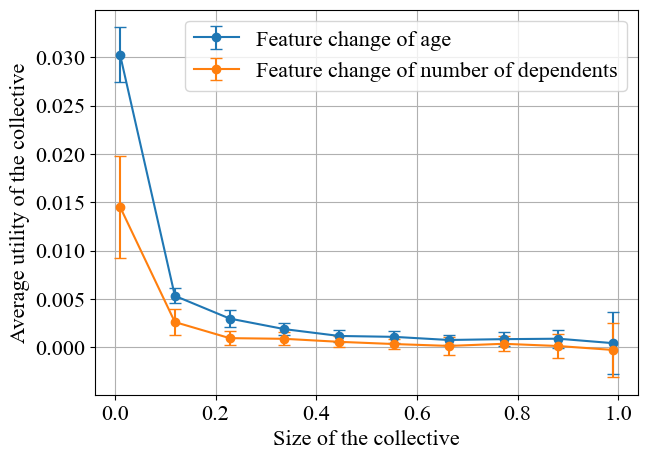

In [ ]:

df_gap_age = pd.read_csv("gap_age_10runs.csv")
df_gap_nd = pd.read_csv("gap_nd_10runs.csv")

df_gap_age  = df_gap_age.drop(['Unnamed: 0'], axis = 1)
df_gap_nd = df_gap_nd.drop(['Unnamed: 0'], axis = 1)

print(df_gap_age)
mean_gap_age = df_gap_age.mean(axis = 1)
mean_gap_nd = df_gap_nd.mean(axis = 1)

std_gap_age = df_gap_age.std(axis = 1)
std_gap_nd = df_gap_nd.std(axis = 1)

plt.figure(figsize=(7,5))
plt.errorbar(
    x=beta_list,
    y=mean_gap_age,
    yerr=std_gap_age,
    fmt='-o',
    capsize=4,
    label='Feature change of age'
)
plt.errorbar(
    x=beta_list,
    y=mean_gap_nd,
    yerr=std_gap_nd,
    fmt='-o',
    capsize=4,
    label='Feature change of number of dependents'
)
plt.grid()
plt.xlabel('Size of the collective')
plt.ylabel('Average utility of the collective')
plt.legend()
plt.savefig("gap_vs_size.pdf")